In [2]:
%matplotlib widget
import ipywidgets as widgets
# from IPython.display import clear_output
import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)

import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd
# import numpy as np
from tqdm.autonotebook import tqdm
from scipy.ndimage import gaussian_filter1d
# import h5py
# import copy
import os
import torch
os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

# import shlex
import torch

from sphMath.sampling import sampleRegularParticles, sampleOptimal
from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
from sphMath.operations import GradientMode, LaplacianMode, SupportScheme
from sphMath.enums import *
from sphMath.schemes.states.common import BasicState
from sphMath.neighborhood import SupportScheme, evaluateNeighborhood
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr, filterNeighborhoodByKind
from sphMath.modules.density import computeDensity

from sphMath.sdf import operatorDict, getSDF
from sphMath.sphOperations.shared import scatter_sum
from matplotlib.colors import LogNorm

from waveEqn import WaveEquationState, waveEquation2
from typing import Union, Tuple
from sphMath.neighborhood import SparseNeighborhood, PrecomputedNeighborhood
from sphMath.operations import GradientMode, LaplacianMode
from sphMath.kernels import SPHKernel
from sphMath.enums import *
from sphMath.operations import SPHOperation, Operation
from sphMath.schemes.states.common import BasicState
from sphMath.neighborhood import SupportScheme, evaluateNeighborhood
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr, filterNeighborhoodByKind
from sphMath.operations import ParticleSetWithQuantity, sph_op
from sphMath.kernels import getSPHKernelv2
from sphMath.plotting import visualizeParticles, updatePlot, plotDistribution
from sphMath.operations import SPHOperation, Operation
from sphMath.util import getPeriodicPositions
from sphMath.integrationSchemes.util import integrateQ
from sphMath.integration import getIntegrator
import copy
from waveEqn import WaveSystem, waveSystemFunction

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
dtype = torch.float32
L = 2
dim = 2
nx = 128

kernel = KernelType.Wendland4
targetNeighbors = n_h_to_nH(4, dim)

domain = buildDomainDescription(L, dim, True, device, dtype)

particles = sampleOptimal(nx, domain, targetNeighbors, kernel, 0., 0, shiftScheme = 'delta')

config = {
    'domain': domain,
    'kernel': kernel,
    'targetNeighbors': targetNeighbors,
    'neighborhood':{
        'verletScale': 1.0
    }
}

config['gradientMode'] = GradientMode.Difference
config['laplacianMode'] = LaplacianMode.Brookshaw
config['supportScheme'] = SupportScheme.Gather
config['integrationScheme'] = IntegrationSchemeType.rungeKutta4

True: dxs: [tensor(0.0156, device='cuda:0'), tensor(0.0156, device='cuda:0')], ns: [tensor(128, device='cuda:0', dtype=torch.int32), tensor(128, device='cuda:0', dtype=torch.int32)], nx: 128


0it [00:00, ?it/s]

In [4]:
particleState = BasicState(particles.positions, particles.supports, particles.masses, particles.densities, torch.zeros_like(particles.positions), torch.zeros(particles.positions.shape[0], device = device, dtype = torch.int64), torch.zeros(particles.positions.shape[0], device = device, dtype = torch.int64), torch.arange(particles.positions.shape[0], device = device), particles.positions.shape[0])
neighborhood, neighbors = evaluateNeighborhood(particleState, config['domain'], kernel, verletScale = config['neighborhood']['verletScale'], mode = SupportScheme.SuperSymmetric, priorNeighborhood=None)
particleState.numNeighbors = coo_to_csr(filterNeighborhoodByKind(particleState, neighbors.neighbors, which = 'noghost')).rowEntries
particleState.densities = computeDensity(particleState, kernel, neighbors.get('noghost'), SupportScheme.Gather, config)

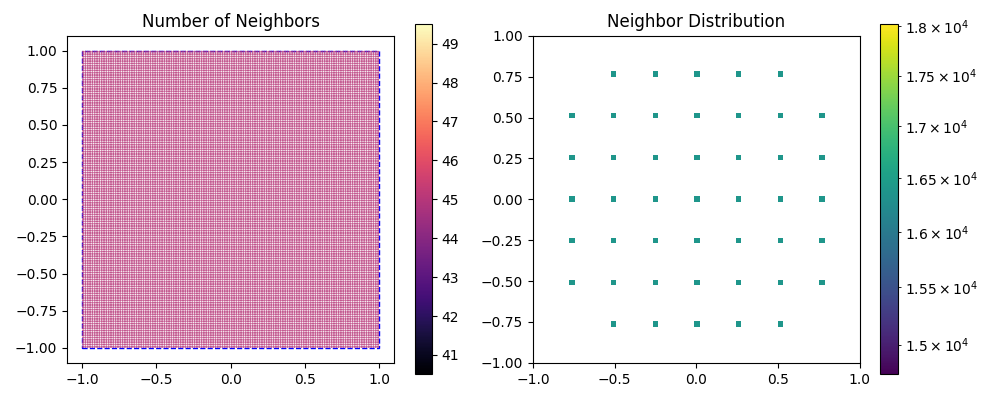

In [5]:
fig, axis = plt.subplots(1,2 , figsize=(10,4), squeeze=False)
visualizeParticles(fig, axis[0,0], particleState, config['domain'], particleState.numNeighbors,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'magma', markerSize = 0.25, gridVisualization = False, title = 'Number of Neighbors')
plotDistribution(fig, axis[0,1], particleState, neighbors.get('noghost'), 63)
fig.tight_layout()

In [6]:
def sampleDamping(particleState, config):
    l = 0.8
    sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([l ,l]))
    sdf = operatorDict['invert'](sphere_b)

    dampGrid = sdf(getPeriodicPositions(particleState.positions, config['domain']).cpu()).to('cuda')
    dampGrid[dampGrid > 0] = 1
    dampGrid[dampGrid < 0] = torch.exp(- (dampGrid[dampGrid < 0] / (1-l))**2 / 4)

    dampGrid[:] = 1
    return dampGrid

In [7]:
def sampleC(particleState, config):
    positions = getPeriodicPositions(particleState.positions, config['domain'])
    cGrid = torch.ones(positions.shape[0], device = 'cuda') * 0.5

    # xx, yy , noise = generateOctaveNoise(n = nx * 4, dim = 2, octaves = 2, baseFrequency = 1, kind = 'perlin', tileable=True, seed = 12365)

    # cTarget = noise / 2 + 0.5

    # # cTarget = torch.where(yy < 0, 1, 0.5)
    # # cTarget[:] = 0.5
    # cTarget = torch.where(torch.sqrt(xx**2 + yy**2) < 0.25, 0, 1)
    # cInterp = RegularGridInterpolator((np.linspace(-1,1,cTarget.shape[0]), np.linspace(-1,1,cTarget.shape[1])), cTarget.numpy())
    # cGrid = torch.tensor(cInterp(getModPosition(grid, config).cpu())).to('cuda')

    # cGrid[:] *= 2 - 1 * torch.abs(grid[:,1])
    # cGrid = sampleVoronoiC(positions)
    cGrid[:] = torch.where(torch.logical_or(
        torch.logical_and(positions[:,0] > 0.5, positions[:,1] < 0.5), 
        torch.logical_and(positions[:,0] < -0.5, positions[:,1] < 0.5)), 0.5, 1)
    # cGrid[:] = torch.where(torch.logical_and(positions[:,0].abs() > 0.125, positions[:,1].abs() < 0.025), 0.0, 1)
    cGrid[:] = 1
    return cGrid

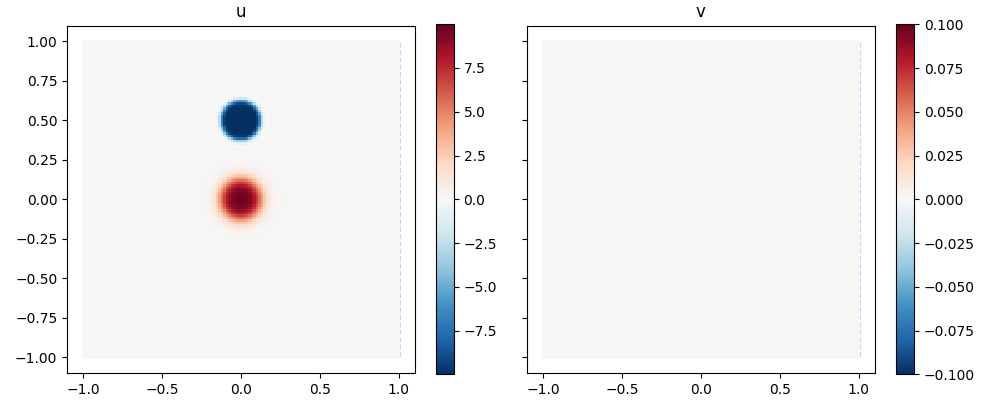

In [9]:
from waveEqn import WaveEquationState, waveEquation2
from typing import Union, Tuple
from sphMath.neighborhood import SparseNeighborhood, PrecomputedNeighborhood
from sphMath.operations import GradientMode, LaplacianMode
from sphMath.kernels import SPHKernel
from sphMath.enums import *
from sphMath.operations import SPHOperation, Operation
from sphMath.schemes.states.common import BasicState
from sphMath.neighborhood import SupportScheme, evaluateNeighborhood
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr, filterNeighborhoodByKind
from sphMath.operations import ParticleSetWithQuantity, sph_op
from sphMath.kernels import getSPHKernelv2



def sampleU(particleState, neighbors, config, center, radius, uMag = 10):
    positions = getPeriodicPositions(particleState.positions, config['domain'])
    sampled = torch.zeros(positions.shape[0], device = positions.device)

    circleFn = lambda points: getSDF('circle')['function'](points, radius)

    circle = circleFn(positions)
    # print('circle:', circle)

    # translated = operatorDict['translate'](circleFn, center)(positions)
    # print('translated:', translated)
    # sampled = torch.where(translated < 0, 1, 0)

    # print('sampled:', sampled)
    # print('center: ', center)
    # sampledSum = torch.sum(sampled)
    # sampledSum.backward()

    translated = operatorDict['translate'](circleFn, center)(positions)
    sampled = torch.nn.Sigmoid()(-translated * 40)

    sampled = sampled - torch.where(operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.125), torch.tensor([0.0,0.5], device = positions.device))(positions) < 0, 1, 0).float()

    # sampled = SPHOperation(
    #     particleState,
    #     sampled,
    #     config['kernel'],
    #     neighbors.get('noghost')[0],
    #     neighbors.get('noghost')[1],
    #     Operation.Interpolate,
    #     supportScheme = SupportScheme.Gather)

    # for _ in range(8):
        # sampled = smoothGrid(gridState, sampled)


    sampled = sampled * uMag
    return sampled

center = torch.tensor([0.0, 0.0], device = 'cuda', dtype= torch.float32)
center.requires_grad = True
radius = torch.tensor(0.125, device = 'cuda', dtype= torch.float32)
# radius.requires_grad = True
u, v = torch.zeros(nx**2, device = 'cuda'), torch.zeros(nx**2, device = 'cuda')
cGrid = sampleC(particleState, config)
dampGrid = sampleDamping(particleState, config)

u = sampleU(particleState, neighbors, config, center, radius, uMag = 10)

initialState = WaveEquationState(
    u = u,
    v = v,
    c = cGrid,
    damping = dampGrid
)

from sphMath.plotting import visualizeParticles, updatePlot

fig, axis = plt.subplots(1,2 , figsize=(10,4), squeeze=False, sharey=True)


uPlot = visualizeParticles(
    fig, axis[0,0], particleState, config['domain'], initialState.u,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

vPlot = visualizeParticles(
    fig, axis[0,1], particleState, config['domain'], initialState.v,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

axis[0,0].set_title('u')
axis[0,1].set_title('v')

fig.tight_layout()


In [12]:
import copy

plotInterval = 50
# state = copy.deepcopy(initialState)
nIter = 250
dt = 0.001
t = 0.0

center = torch.tensor([0.0, 0.0], device = 'cuda', dtype= torch.float32)
center.requires_grad = True
radius = torch.tensor(0.125, device = 'cuda', dtype= torch.float32)
# radius.requires_grad = True

optimizer = torch.optim.Adam([center], lr = 1e-3)
integrator = getIntegrator(config['integrationScheme'])

In [13]:
for i in (tq := tqdm(range(100))):
    optimizer.zero_grad()
    u = sampleU(particleState, neighbors, config, center, radius, uMag = 10)

    waveSystem = WaveSystem(
        systemState = particleState,
        waveState = WaveEquationState(
            u = u,
            v = v,
            c = cGrid,
            damping = dampGrid
        ),
        neighborhood = neighbors.get('noghost'),
        t = t
    )

    updatePlot(uPlot, particleState, waveSystem.waveState.u)
    updatePlot(vPlot, particleState, waveSystem.waveState.v)

    for i in tqdm(range(nIter), leave = False):
        waveSystem, updates =  integrator.function(
            waveSystem,
            dt = dt,
            f = waveSystemFunction,
            verbose = False,
            config = config,
        )
        t += dt

        # if i % plotInterval == 0 or i == nIter - 1:
        #     updatePlot(uPlot, particleState, waveSystem.waveState.u)
        #     updatePlot(vPlot, particleState, waveSystem.waveState.v)

        #     fig.canvas.draw()
        #     fig.canvas.flush_events()

    targetLocation = torch.tensor([0.0, 0.25], device = 'cuda', dtype= torch.float32)
    distanceToTarget = particleState.positions - targetLocation
    distanceToTarget = torch.sqrt(distanceToTarget[:,0]**2 + distanceToTarget[:,1]**2)
    isNeighbor = distanceToTarget < particleState.supports
    neighbor_j = torch.arange(particleState.positions.shape[0], device = 'cuda')[isNeighbor]
    neighbor_i = torch.zeros_like(neighbor_j, device = 'cuda')

    referenceParticles = ParticleSetWithQuantity(positions = targetLocation.view(1,2), supports = torch.ones(1, device = 'cuda'), masses = torch.ones(1, device = 'cuda'), densities = torch.ones(1, device = 'cuda'), quantities = torch.zeros(1, device = 'cuda'))
    quantizedParticles = ParticleSetWithQuantity(particleState.positions, particleState.supports, particleState.masses, particleState.densities, waveSystem.waveState.u)

    sparseNeighborhood = SparseNeighborhood(
        points_a= referenceParticles,
        points_b= quantizedParticles,
        row = neighbor_i,
        col = neighbor_j,
        numRows = 1,
        numCols = particleState.positions.shape[0],
        domain = config['domain']
    )

    interpolated = sph_op(referenceParticles, quantizedParticles, domain, getSPHKernelv2(kernel), sparseNeighborhood, operation = 'interpolate', supportScheme='scatter')

    loss = (5 - interpolated)**2
    loss.backward()
    optimizer.step()

    tq.set_description(f'loss: {loss.item():.4f}, center: {center}, radius: {radius.item():.4f}')



  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

loss: 19.9058, center: tensor([ 0.0721, -0.0535], device='cuda:0', requires_grad=True), radius: 0.1250


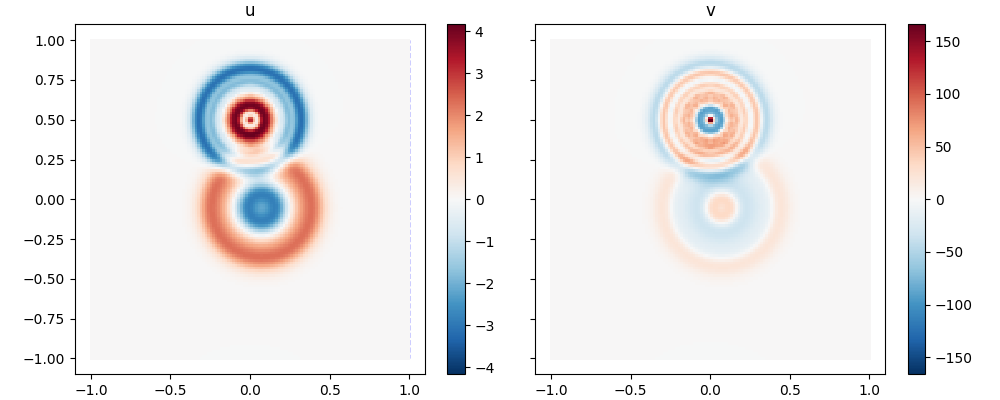

In [ ]:
u = sampleU(particleState, neighbors, config, center, radius, uMag = 10)

waveSystem = WaveSystem(
    systemState = particleState,
    waveState = WaveEquationState(
        u = u,
        v = v,
        c = cGrid,
        damping = dampGrid
    ),
    neighborhood = neighbors.get('noghost'),
    t = t
)


for i in tqdm(range(nIter), leave = False):
    waveSystem, updates =  integrator.function(
        waveSystem,
        dt = dt,
        f = waveSystemFunction,
        verbose = False,
        config = config,
    )
    t += dt

fig, axis = plt.subplots(1,2 , figsize=(10,4), squeeze=False, sharey=True)

uPlot = visualizeParticles(
    fig, axis[0,0], particleState, config['domain'], waveSystem.waveState.u,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

vPlot = visualizeParticles(
    fig, axis[0,1], particleState, config['domain'], waveSystem.waveState.v,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

axis[0,0].set_title('u')
axis[0,1].set_title('v')

fig.tight_layout()

targetLocation = torch.tensor([0.0, 0.25], device = 'cuda', dtype= torch.float32)
distanceToTarget = particleState.positions - targetLocation
distanceToTarget = torch.sqrt(distanceToTarget[:,0]**2 + distanceToTarget[:,1]**2)
isNeighbor = distanceToTarget < particleState.supports
neighbor_j = torch.arange(particleState.positions.shape[0], device = 'cuda')[isNeighbor]
neighbor_i = torch.zeros_like(neighbor_j, device = 'cuda')

referenceParticles = ParticleSetWithQuantity(positions = targetLocation.view(1,2), supports = torch.ones(1, device = 'cuda'), masses = torch.ones(1, device = 'cuda'), densities = torch.ones(1, device = 'cuda'), quantities = torch.zeros(1, device = 'cuda'))
quantizedParticles = ParticleSetWithQuantity(particleState.positions, particleState.supports, particleState.masses, particleState.densities, waveSystem.waveState.u)

sparseNeighborhood = SparseNeighborhood(
    points_a= referenceParticles,
    points_b= quantizedParticles,
    row = neighbor_i,
    col = neighbor_j,
    numRows = 1,
    numCols = particleState.positions.shape[0],
    domain = config['domain']
)

interpolated = sph_op(referenceParticles, quantizedParticles, domain, getSPHKernelv2(kernel), sparseNeighborhood, operation = 'interpolate', supportScheme='scatter')

loss = (5 - interpolated)**2
print(f'loss: {loss.item():.4f}, center: {center}, radius: {radius.item():.4f}')

  0%|          | 0/250 [00:00<?, ?it/s]

loss: 25.7548, center: tensor([0., 0.], device='cuda:0'), radius: 0.1250


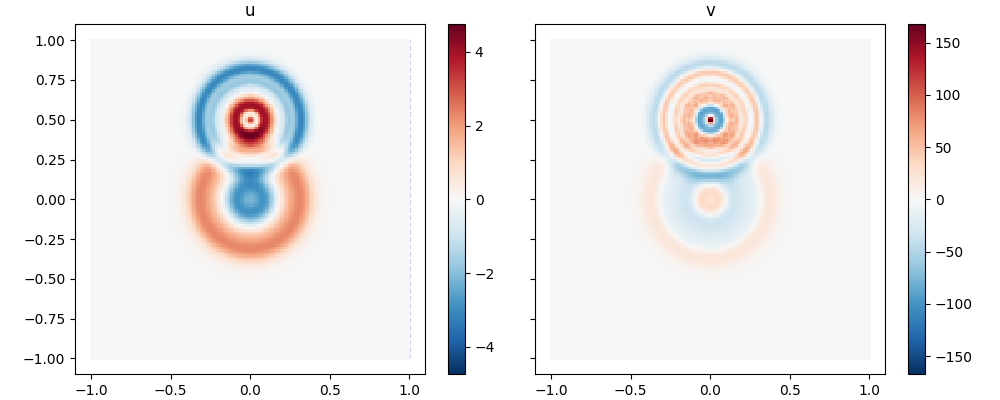

In [17]:
zeroCenter = torch.tensor([0.0, 0.0], device = 'cuda', dtype= torch.float32)
u = sampleU(particleState, neighbors, config, zeroCenter, radius, uMag = 10)

waveSystem = WaveSystem(
    systemState = particleState,
    waveState = WaveEquationState(
        u = u,
        v = v,
        c = cGrid,
        damping = dampGrid
    ),
    neighborhood = neighbors.get('noghost'),
    t = t
)


for i in tqdm(range(nIter), leave = False):
    waveSystem, updates =  integrator.function(
        waveSystem,
        dt = dt,
        f = waveSystemFunction,
        verbose = False,
        config = config,
    )
    t += dt

fig, axis = plt.subplots(1,2 , figsize=(10,4), squeeze=False, sharey=True)

uPlot = visualizeParticles(
    fig, axis[0,0], particleState, config['domain'], waveSystem.waveState.u,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

vPlot = visualizeParticles(
    fig, axis[0,1], particleState, config['domain'], waveSystem.waveState.v,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

axis[0,0].set_title('u')
axis[0,1].set_title('v')

fig.tight_layout()

targetLocation = torch.tensor([0.0, 0.25], device = 'cuda', dtype= torch.float32)
distanceToTarget = particleState.positions - targetLocation
distanceToTarget = torch.sqrt(distanceToTarget[:,0]**2 + distanceToTarget[:,1]**2)
isNeighbor = distanceToTarget < particleState.supports
neighbor_j = torch.arange(particleState.positions.shape[0], device = 'cuda')[isNeighbor]
neighbor_i = torch.zeros_like(neighbor_j, device = 'cuda')

referenceParticles = ParticleSetWithQuantity(positions = targetLocation.view(1,2), supports = torch.ones(1, device = 'cuda'), masses = torch.ones(1, device = 'cuda'), densities = torch.ones(1, device = 'cuda'), quantities = torch.zeros(1, device = 'cuda'))
quantizedParticles = ParticleSetWithQuantity(particleState.positions, particleState.supports, particleState.masses, particleState.densities, waveSystem.waveState.u)

sparseNeighborhood = SparseNeighborhood(
    points_a= referenceParticles,
    points_b= quantizedParticles,
    row = neighbor_i,
    col = neighbor_j,
    numRows = 1,
    numCols = particleState.positions.shape[0],
    domain = config['domain']
)

interpolated = sph_op(referenceParticles, quantizedParticles, domain, getSPHKernelv2(kernel), sparseNeighborhood, operation = 'interpolate', supportScheme='scatter')

loss = (5 - interpolated)**2
print(f'loss: {loss.item():.4f}, center: {zeroCenter}, radius: {radius.item():.4f}')

  0%|          | 0/250 [00:00<?, ?it/s]

loss: 20.466482162475586
center: tensor([ 0.0744, -0.0542], device='cuda:0', requires_grad=True)


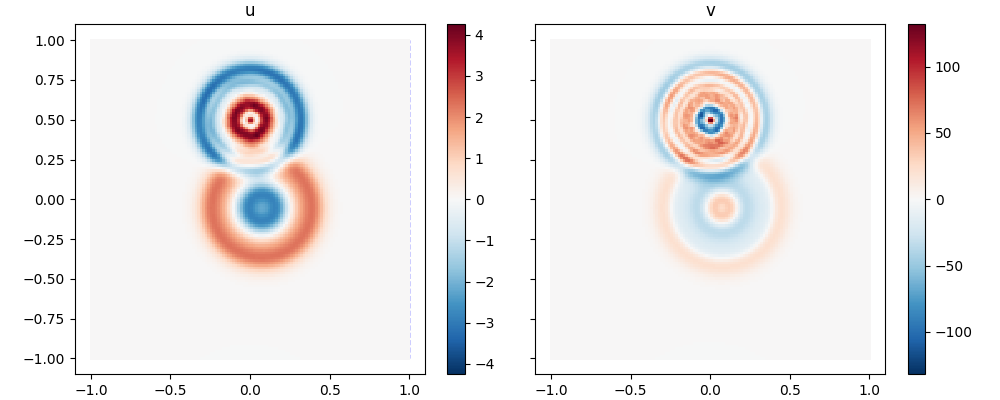

In [117]:

optimizer.zero_grad()

u = sampleU(particleState, neighbors, config, center, radius, uMag = 10)

state = WaveEquationState(
    u = u,
    v = v,
    c = cGrid,
    damping = dampGrid
)

updatePlot(uPlot, particleState, initialState.u)
updatePlot(vPlot, particleState, initialState.v)

for i in tqdm(range(nIter), leave = False):
    u_next, v_next = integrateState(t, dt, state, particleState, kernel, neighbors.get('noghost'), scheme = 'RK4', gradientMode = GradientMode.Difference, laplacianMode = LaplacianMode.Brookshaw, supportScheme = SupportScheme.Gather)

    state.u = u_next
    state.v = v_next
    t += dt

    # if i % plotInterval == 0 or i == nIter - 1:
    #     updatePlot(uPlot, particleState, u_next)
    #     updatePlot(vPlot, particleState, v_next)

    #     fig.canvas.draw()
    #     fig.canvas.flush_events()

targetLocation = torch.tensor([0.0, 0.25], device = 'cuda', dtype= torch.float32)
distanceToTarget = particleState.positions - targetLocation
distanceToTarget = torch.sqrt(distanceToTarget[:,0]**2 + distanceToTarget[:,1]**2)
isNeighbor = distanceToTarget < particleState.supports
neighbor_j = torch.arange(particleState.positions.shape[0], device = 'cuda')[isNeighbor]
neighbor_i = torch.zeros_like(neighbor_j, device = 'cuda')

referenceParticles = ParticleSetWithQuantity(positions = targetLocation.view(1,2), supports = torch.ones(1, device = 'cuda'), masses = torch.ones(1, device = 'cuda'), densities = torch.ones(1, device = 'cuda'), quantities = torch.zeros(1, device = 'cuda'))
quantizedParticles = ParticleSetWithQuantity(particleState.positions, particleState.supports, particleState.masses, particleState.densities, state.u)

sparseNeighborhood = SparseNeighborhood(
    points_a= referenceParticles,
    points_b= quantizedParticles,
    row = neighbor_i,
    col = neighbor_j,
    numRows = 1,
    numCols = particleState.positions.shape[0],
    domain = config['domain']
)

interpolated = sph_op(referenceParticles, quantizedParticles, domain, getSPHKernelv2(kernel), sparseNeighborhood, operation = 'interpolate', supportScheme='scatter')

loss = (5 - interpolated)**2

print('loss:', loss.item())
print('center:', center)

from waveEqn import WaveEquationState, waveEquation2, integrateState
from typing import Union, Tuple
from sphMath.neighborhood import SparseNeighborhood, PrecomputedNeighborhood
from sphMath.operations import GradientMode, LaplacianMode
from sphMath.kernels import SPHKernel
from sphMath.enums import *
from sphMath.operations import SPHOperation, Operation
from sphMath.schemes.states.common import BasicState
from sphMath.neighborhood import SupportScheme, evaluateNeighborhood
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr, filterNeighborhoodByKind
from sphMath.operations import ParticleSetWithQuantity, sph_op
from sphMath.kernels import getSPHKernelv2



def sampleU(particleState, neighbors, config, center, radius, uMag = 10):
    positions = getModPosition(particleState.positions, config)
    sampled = torch.zeros(positions.shape[0], device = positions.device)

    circleFn = lambda points: getSDF('circle')['function'](points, radius)

    circle = circleFn(positions)
    # print('circle:', circle)

    # translated = operatorDict['translate'](circleFn, center)(positions)
    # print('translated:', translated)
    # sampled = torch.where(translated < 0, 1, 0)

    # print('sampled:', sampled)
    # print('center: ', center)
    # sampledSum = torch.sum(sampled)
    # sampledSum.backward()

    translated = operatorDict['translate'](circleFn, center)(positions)
    sampled = torch.nn.Sigmoid()(-translated * 40)

    sampled = sampled - torch.where(operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.125), torch.tensor([0.0,0.5], device = positions.device))(positions) < 0, 1, 0).float()

    # sampled = SPHOperation(
    #     particleState,
    #     sampled,
    #     config['kernel'],
    #     neighbors.get('noghost')[0],
    #     neighbors.get('noghost')[1],
    #     Operation.Interpolate,
    #     supportScheme = SupportScheme.Gather)

    # for _ in range(8):
        # sampled = smoothGrid(gridState, sampled)


    sampled = sampled * uMag
    return sampled

fig, axis = plt.subplots(1,2 , figsize=(10,4), squeeze=False, sharey=True)


uPlot = visualizeParticles(
    fig, axis[0,0], particleState, config['domain'], state.u,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

vPlot = visualizeParticles(
    fig, axis[0,1], particleState, config['domain'], state.v,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

axis[0,0].set_title('u')
axis[0,1].set_title('v')

fig.tight_layout()


# loss.backward()
# optimizer.step()

# tq.set_description(f'loss: {loss.item():.4f}, center: {center}, radius: {radius.item():.4f}')



  0%|          | 0/250 [00:00<?, ?it/s]

loss: 20.466474533081055
center: tensor([0., 0.], device='cuda:0')


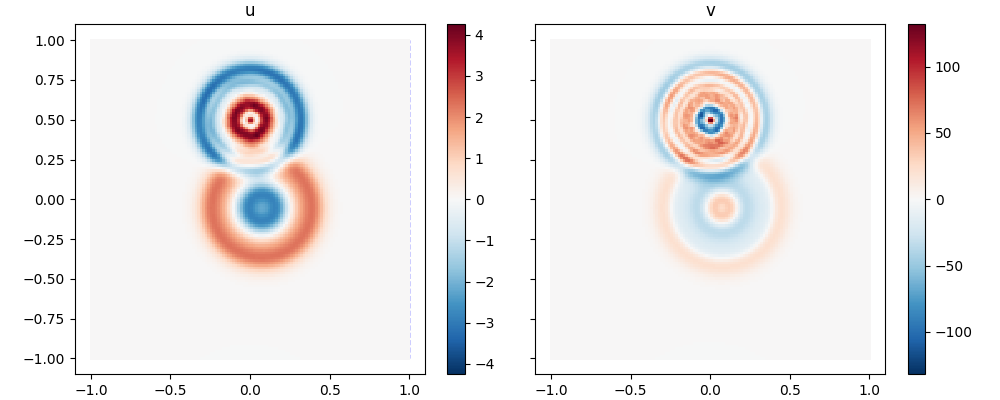

In [119]:

optimizer.zero_grad()
zeroCenter = torch.tensor([0,0], device=device,dtype=dtype)
u = sampleU(particleState, neighbors, config, center, radius, uMag = 10)

state = WaveEquationState(
    u = u,
    v = v,
    c = cGrid,
    damping = dampGrid
)

updatePlot(uPlot, particleState, initialState.u)
updatePlot(vPlot, particleState, initialState.v)

for i in tqdm(range(nIter), leave = False):
    u_next, v_next = integrateState(t, dt, state, particleState, kernel, neighbors.get('noghost'), scheme = 'RK4', gradientMode = GradientMode.Difference, laplacianMode = LaplacianMode.Brookshaw, supportScheme = SupportScheme.Gather)

    state.u = u_next
    state.v = v_next
    t += dt

    # if i % plotInterval == 0 or i == nIter - 1:
    #     updatePlot(uPlot, particleState, u_next)
    #     updatePlot(vPlot, particleState, v_next)

    #     fig.canvas.draw()
    #     fig.canvas.flush_events()

targetLocation = torch.tensor([0.0, 0.25], device = 'cuda', dtype= torch.float32)
distanceToTarget = particleState.positions - targetLocation
distanceToTarget = torch.sqrt(distanceToTarget[:,0]**2 + distanceToTarget[:,1]**2)
isNeighbor = distanceToTarget < particleState.supports
neighbor_j = torch.arange(particleState.positions.shape[0], device = 'cuda')[isNeighbor]
neighbor_i = torch.zeros_like(neighbor_j, device = 'cuda')

referenceParticles = ParticleSetWithQuantity(positions = targetLocation.view(1,2), supports = torch.ones(1, device = 'cuda'), masses = torch.ones(1, device = 'cuda'), densities = torch.ones(1, device = 'cuda'), quantities = torch.zeros(1, device = 'cuda'))
quantizedParticles = ParticleSetWithQuantity(particleState.positions, particleState.supports, particleState.masses, particleState.densities, state.u)

sparseNeighborhood = SparseNeighborhood(
    points_a= referenceParticles,
    points_b= quantizedParticles,
    row = neighbor_i,
    col = neighbor_j,
    numRows = 1,
    numCols = particleState.positions.shape[0],
    domain = config['domain']
)

interpolated = sph_op(referenceParticles, quantizedParticles, domain, getSPHKernelv2(kernel), sparseNeighborhood, operation = 'interpolate', supportScheme='scatter')

loss = (5 - interpolated)**2

print('loss:', loss.item())
print('center:', zeroCenter)


fig, axis = plt.subplots(1,2 , figsize=(10,4), squeeze=False, sharey=True)


uPlot = visualizeParticles(
    fig, axis[0,0], particleState, config['domain'], state.u,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

vPlot = visualizeParticles(
    fig, axis[0,1], particleState, config['domain'], state.v,
    kernel, which = 'both', visualizeBoth = True, cbar = True, cmap = 'RdBu_r', markerSize = 0.25, gridVisualization = True, scaling ='sym', midPoint = 0.0)

axis[0,0].set_title('u')
axis[0,1].set_title('v')

fig.tight_layout()

# loss.backward()
# optimizer.step()

# tq.set_description(f'loss: {loss.item():.4f}, center: {center}, radius: {radius.item():.4f}')



In [ ]:

print(center.grad)

tensor([3.0067], device='cuda:0', grad_fn=<SPHInterpolationBackward>)
tensor([-4.0235e+01, -1.0025e-02], device='cuda:0')
